#*4.3.2	XGBoost Regression*

#**Chapter 4.3.2**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

# Import librries 
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import glob #for maps
import plotly.graph_objects as go
import plotly.offline
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import itertools
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
warnings.filterwarnings("ignore")
import plotly.express as px
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import TimeSeriesSplit
import warnings
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from numpy import absolute
from numpy import square
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost import plot_importance, plot_tree

##**Data Preprocessing**

In [ ]:
all_files = glob.glob('/content/gdrive/MyDrive/Sent/Ground/' +"*.csv")
all_files_1 = glob.glob('/content/gdrive/MyDrive/Sent/Ground1/' +"*.csv")
li = []
for filename in all_files:
  df= pd.read_csv(filename, index_col=None, header=0)
  li.append(df)

df = pd.concat(li, ignore_index=True)
li1 = []
for filename in all_files_1:
  df1= pd.read_csv(filename, index_col=None, header=0)
  li1.append(df1)

df1 = pd.concat(li1, ignore_index=True)
data10= pd.concat([df,df1])
print(df.shape)
print(df1.shape)
print(data10.shape)
print(data10['country'].unique())
data10 = data10.loc[(data10['country'] == 'DE')]
print(data10['parameter'].unique())
table = pd.pivot_table(data10, values='value', index=['city','utc','latitude','longitude'],columns=['parameter'])
table = table.reset_index()
print(table.head(5))
print(table.shape)
air_data_ground = table.fillna(table.mean())
air_data_ground = air_data_ground.loc[(air_data_ground['pm10'] < 20) & (air_data_ground['pm25'] < 20)]
air_data_ground["utc"] = pd.to_datetime(air_data_ground["utc"]).dt.normalize()
air_data_ground["utc"] = pd.to_datetime(air_data_ground["utc"]).dt.tz_localize(None)
air_data_ground=air_data_ground.groupby('utc')[['pm10', 'pm25']].mean()
air_data_ground = air_data_ground.reset_index()
air_data_ground 
fin_data = pd.read_csv('/content/gdrive/MyDrive/Sent/final_data_May20_Sept22.csv') #without outliers |

(524184, 11)
(233039, 11)
(757223, 11)
['DE' 'US']
['pm10' 'pm25']
parameter    city                        utc   latitude  longitude  pm10  pm25
0          Berlin  2020-05-01T00:00:00+00:00  52.438115  13.387720  6.94   NaN
1          Berlin  2020-05-01T00:00:00+00:00  52.463611  13.318250  7.02   NaN
2          Berlin  2020-05-01T00:00:00+00:00  52.467534  13.441654  7.64   NaN
3          Berlin  2020-05-01T00:00:00+00:00  52.473192  13.225144  5.99   NaN
4          Berlin  2020-05-01T00:00:00+00:00  52.481709  13.433967  6.95   NaN
(22254, 6)


In [ ]:
fin_data.head()

,latitude,longitute,Year,Month,Day,Hour,nitrogendioxide_tropospheric_column,nitrogendioxide_tropospheric_column_precision,nitrogendioxide_tropospheric_column_precision_kernel,air_mass_factor_troposphere,air_mass_factor_total,tm5_tropopause_layer_index,qa_value,utc,date,pm10,pm25
0,52.157350,13.716069,2020.0,5.0,1.0,11.0,1.459978e-05,0.000018,0.000017,0.952377,1.804340,14.0,0.0074,2020-05-01,2020-05-01 11:00:00,6.2615,11.934496
1,52.192528,13.806399,2020.0,5.0,1.0,11.0,-6.227974e-06,0.000014,0.000014,0.951523,1.798625,14.0,0.0074,2020-05-01,2020-05-01 11:00:00,6.2615,11.934496
2,52.227226,13.895948,2020.0,5.0,1.0,11.0,5.757178e-07,0.000013,0.000013,0.918600,1.780306,14.0,0.0074,2020-05-01,2020-05-01 11:00:00,6.2615,11.934496
3,52.167213,13.589217,2020.0,5.0,1.0,11.0,1.580315e-05,0.000011,0.000011,1.077755,1.861350,14.0,0.0074,2020-05-01,2020-05-01 11:00:00,6.2615,11.934496
4,52.202910,13.680410,2020.0,5.0,1.0,11.0,1.687531e-05,0.000016,0.000015,1.005521,1.828623,14.0,0.0074,2020-05-01,2020-05-01 11:00:00,6.2615,11.934496


In [ ]:
data_LSTM_test= fin_data.groupby(['utc'])['nitrogendioxide_tropospheric_column','nitrogendioxide_tropospheric_column_precision','nitrogendioxide_tropospheric_column_precision_kernel','air_mass_factor_troposphere', 'air_mass_factor_total',	'pm10'].mean()

In [ ]:
data_LSTM_test = data_LSTM_test.reset_index()

In [ ]:
data_LSTM_test.head()

,utc,nitrogendioxide_tropospheric_column,nitrogendioxide_tropospheric_column_precision,nitrogendioxide_tropospheric_column_precision_kernel,air_mass_factor_troposphere,air_mass_factor_total,pm10
0,2020-05-01,0.000012,0.000012,0.000012,1.237246,2.027335,6.261500
1,2020-05-02,0.000037,0.000017,0.000015,1.116818,1.851356,7.395500
2,2020-05-03,0.000041,0.000021,0.000020,0.819890,1.837840,10.091111
3,2020-05-04,0.000055,0.000029,0.000027,0.937185,1.422979,15.311250
4,2020-05-05,0.000028,0.000016,0.000015,1.289110,2.089066,10.266667


In [ ]:
df = data_LSTM_test['pm10'].shift(1)

In [ ]:
data_LSTM_test['pm10_lagged'] = df

In [ ]:
data_LSTM_test = data_LSTM_test.dropna()

In [ ]:
data_LSTM_test = data_LSTM_test[['utc','nitrogendioxide_tropospheric_column'	,'nitrogendioxide_tropospheric_column_precision'	,'nitrogendioxide_tropospheric_column_precision_kernel'	, 'air_mass_factor_troposphere', 'air_mass_factor_total',	'pm10_lagged', 'pm10']]
data_LSTM_test['utc'] = pd.to_datetime(data_LSTM_test['utc'], format='%Y-%m-%d')

In [ ]:
data_LSTM_test.head()

,utc,nitrogendioxide_tropospheric_column,nitrogendioxide_tropospheric_column_precision,nitrogendioxide_tropospheric_column_precision_kernel,air_mass_factor_troposphere,air_mass_factor_total,pm10_lagged,pm10
1,2020-05-02,0.000037,0.000017,0.000015,1.116818,1.851356,6.261500,7.395500
2,2020-05-03,0.000041,0.000021,0.000020,0.819890,1.837840,7.395500,10.091111
3,2020-05-04,0.000055,0.000029,0.000027,0.937185,1.422979,10.091111,15.311250
4,2020-05-05,0.000028,0.000016,0.000015,1.289110,2.089066,15.311250,10.266667
5,2020-05-06,0.000038,0.000015,0.000013,1.126148,2.157804,10.266667,7.549048


##**XGboost Model**

**Reference:**

The model scrip was adopted from the following webpage: 

https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost


https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost

In [ ]:
#split date before after certain date 
split_date = '2022-01-01'
pm_train = data_LSTM_test.loc[data_LSTM_test['utc'] <= split_date].copy()
pm_test = data_LSTM_test.loc[data_LSTM_test['utc'] > split_date].copy()

In [ ]:
pm_test_l = pd.DataFrame(pm_test.iloc[:,-1]) #target
pm_train_l = pd.DataFrame(pm_train.iloc[:,-1])

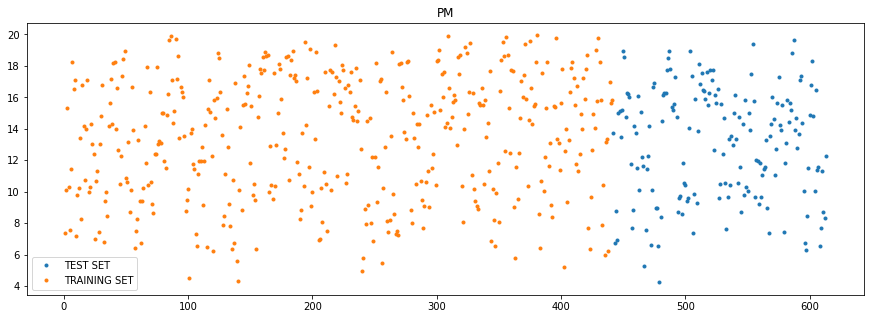

In [ ]:
_ = pm_test_l \
    .rename(columns={'pm10': 'TEST SET'}) \
    .join(pm_train_l.rename(columns={'pm10': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PM', style='.')

In [ ]:
#https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df['utc']
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df = df.drop(columns=['pm10'])
    df = df.drop(columns=['utc'])
    df = df.drop(columns=['date'])
    return df

In [ ]:
X_train = create_features(pm_train)
y_train = pd.DataFrame(pm_train['pm10'])
X_test= create_features(pm_test)
y_test = pd.DataFrame(pm_test['pm10'])

In [ ]:
#define parameters for grid search

params = {
        'min_child_weight': [100, 200, 300, 350],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5, 8, 7]
        }

In [ ]:
#define timer as we are curious about it, as it is an ensemble method, hence time is importnat 

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=1001 ) #StratifiedKFold

start_time = timer(None) # timing starts from this point for "start_time" variable
print(random_search.fit(X_train, y_train))
timer(start_time) # timing ends here f

In [ ]:
model1= XGBRegressor(objective='reg:squarederror', n_estimators=500, max_depth=10, eta=0.5, subsample=1, colsample_bytree=0.8) #model architecture

Mean MAE: 3.388 (0.458)
Mean MSE: 11.691 (3.340)
[0]	validation_0-mae:11.6388	validation_1-mae:11.2892
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:10.4864	validation_1-mae:10.1611
[2]	validation_0-mae:9.45923	validation_1-mae:9.13312
[3]	validation_0-mae:8.53	validation_1-mae:8.21597
[4]	validation_0-mae:7.70674	validation_1-mae:7.40371
[5]	validation_0-mae:6.99369	validation_1-mae:6.71971
[6]	validation_0-mae:6.34113	validation_1-mae:6.14598
[7]	validation_0-mae:5.75844	validation_1-mae:5.60071
[8]	validation_0-mae:5.24007	validation_1-mae:5.12591
[9]	validation_0-mae:4.7596	validation_1-mae:4.72335
[10]	validation_0-mae:4.34608	validation_1-mae:4.43505
[11]	validation_0-mae:3.96417	validation_1-mae:4.19188
[12]	validation_0-mae:3.61917	validation_1-mae:3.96468
[13]	validation_0-mae:3.31535	validation_1-mae:3.77835
[14]	validation_0-mae:3.0457	validatio

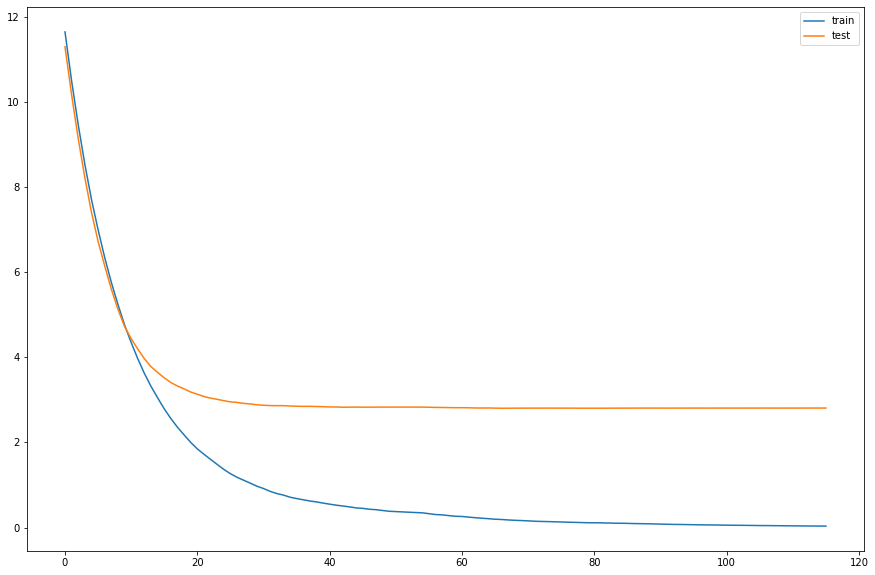

In [ ]:
#Tain folds, train the model 

cv = TimeSeriesSplit(n_splits=10)
# evaluate model
scores = cross_val_score(model1, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores1 = absolute(scores)
scores2 = square(scores)
print('Mean MAE: %.3f (%.3f)' % (scores1.mean(), scores1.std()) )
print('Mean MSE: %.3f (%.3f)' % (scores2.mean(), scores2.std()) )

#model1.fit(X_train, y_train)

model1.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)], 
            early_stopping_rounds=50, eval_metric='mae')

results = model1.evals_result()
# plot history
plt.figure(figsize=(15, 10))
pyplot.plot(results['validation_0']['mae'], label='train')
pyplot.plot(results['validation_1']['mae'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
y_test['pred1'] = model1.predict(X_test)

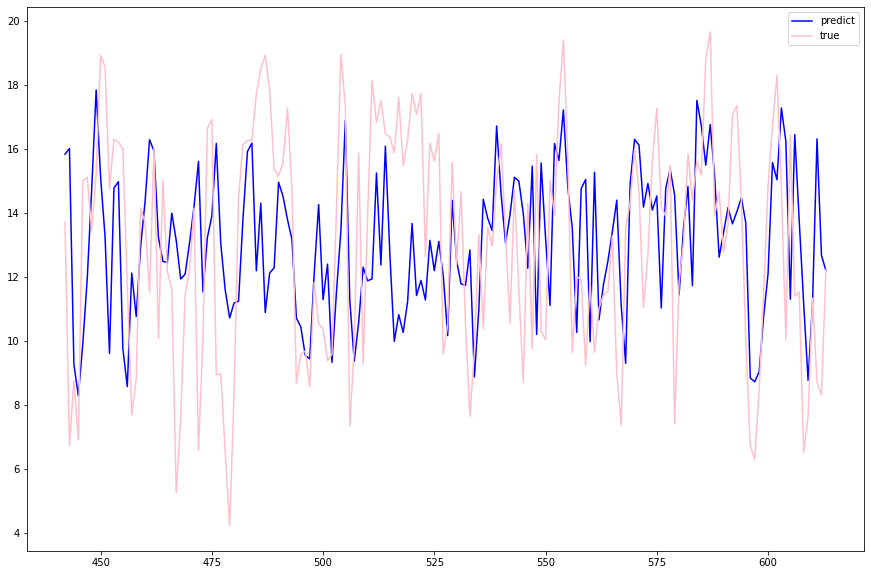

In [ ]:
plt.figure(figsize=(15, 10))

pyplot.plot(y_test['pred1'], label='predict', color = 'blue')
pyplot.plot(y_test['pm10'], label='true', color = 'pink')
pyplot.legend()

pyplot.show()

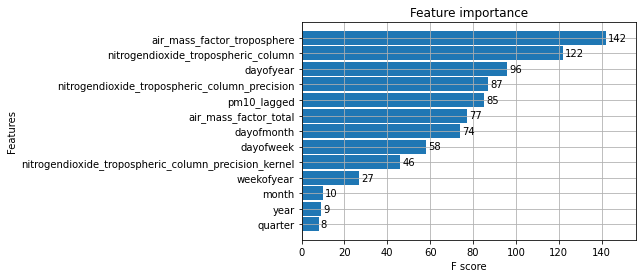

In [ ]:
_ = plot_importance(model1, height=0.9)